<>:112: SyntaxWarning: invalid escape sequence '\o'
<>:113: SyntaxWarning: invalid escape sequence '\o'
<>:166: SyntaxWarning: invalid escape sequence '\o'
<>:167: SyntaxWarning: invalid escape sequence '\o'
<>:176: SyntaxWarning: invalid escape sequence '\o'
<>:112: SyntaxWarning: invalid escape sequence '\o'
<>:113: SyntaxWarning: invalid escape sequence '\o'
<>:166: SyntaxWarning: invalid escape sequence '\o'
<>:167: SyntaxWarning: invalid escape sequence '\o'
<>:176: SyntaxWarning: invalid escape sequence '\o'
C:\Users\brand\AppData\Local\Temp\ipykernel_27420\801860177.py:112: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Mass (M$_\oplus$)")
C:\Users\brand\AppData\Local\Temp\ipykernel_27420\801860177.py:113: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Radius (R$_\oplus$)")
C:\Users\brand\AppData\Local\Temp\ipykernel_27420\801860177.py:166: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Mass (M$_\oplus$)")
C:\Users\brand\AppData\Local\Temp\ipyker

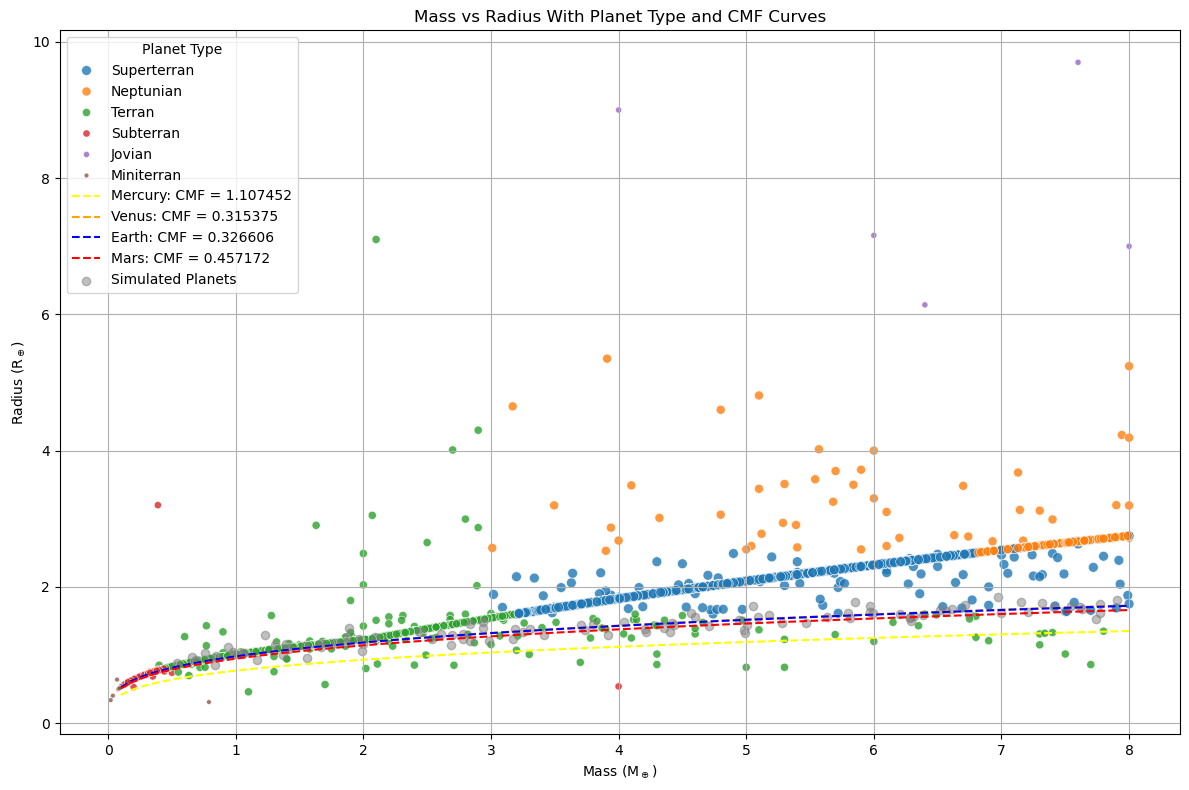

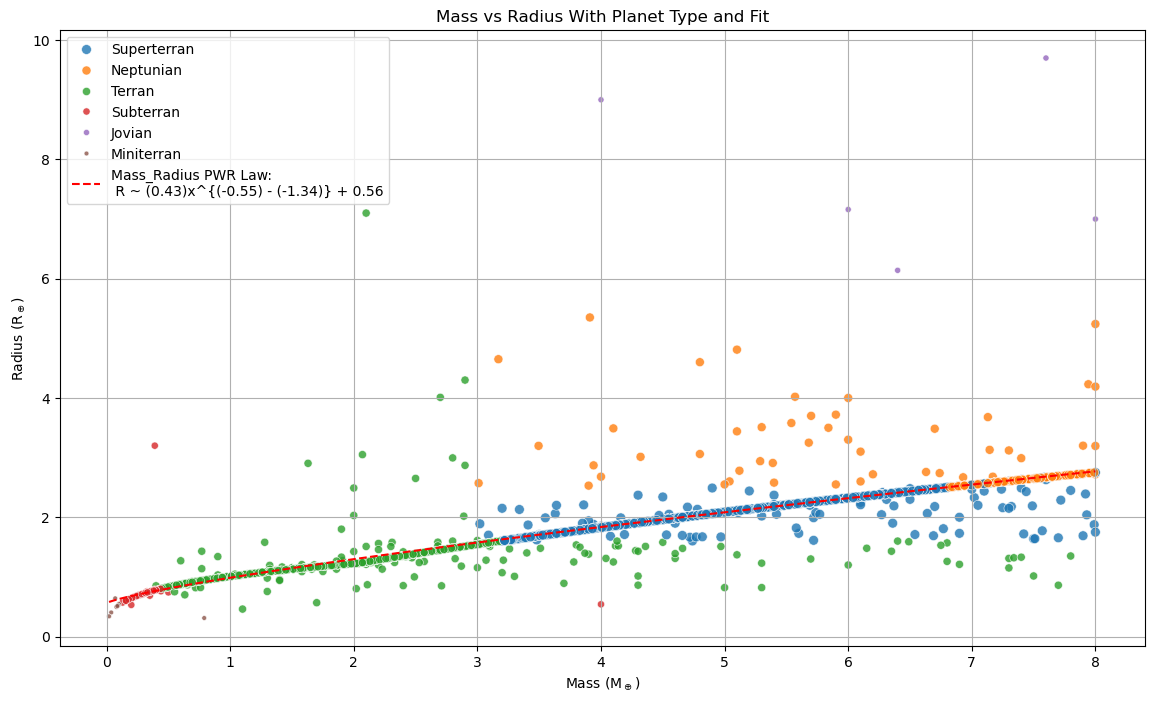

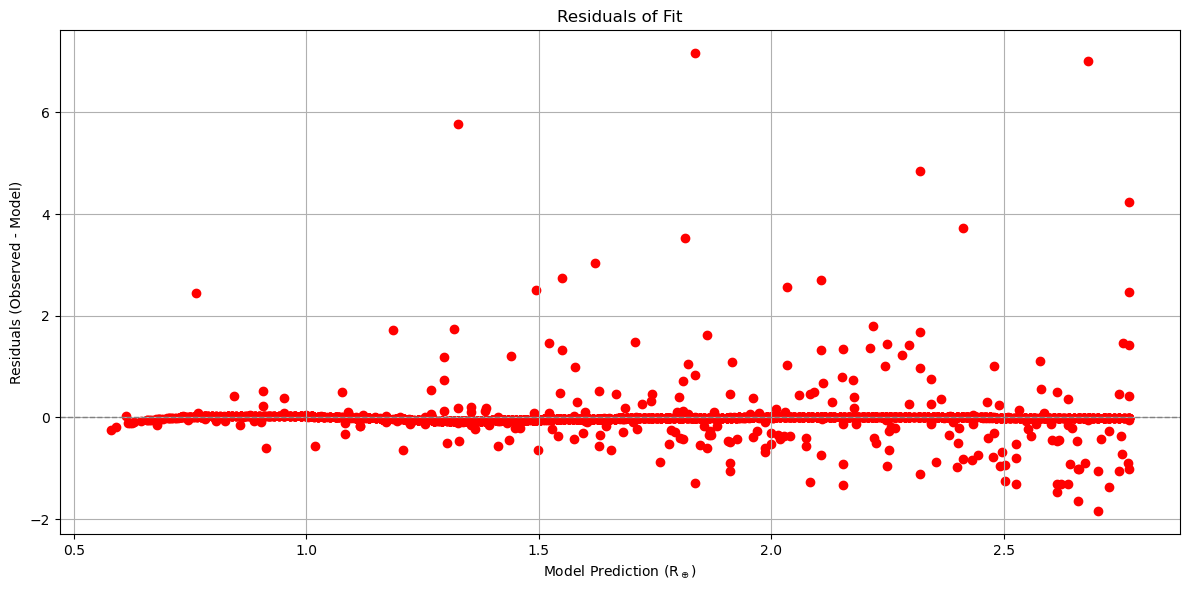

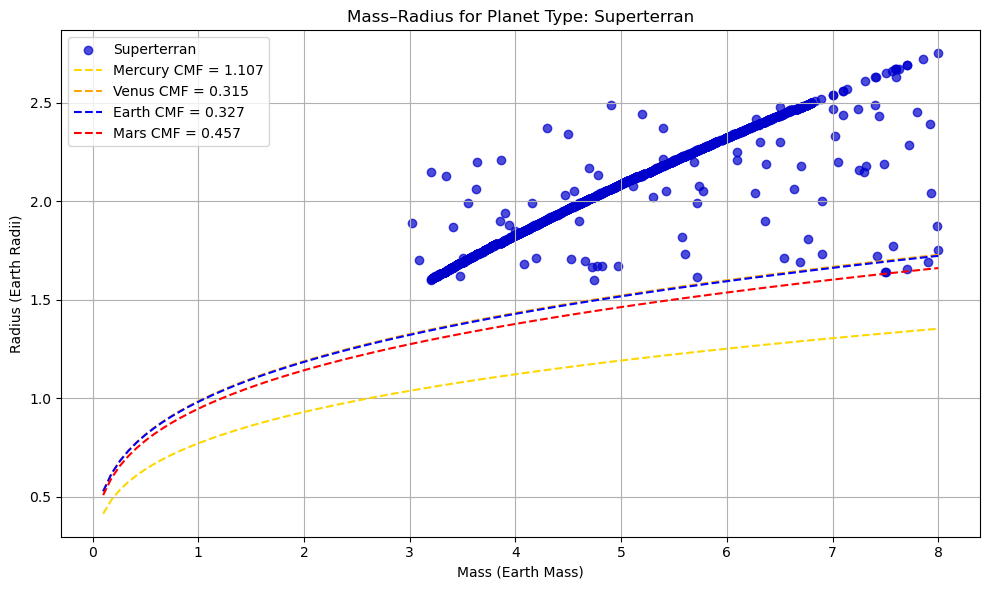

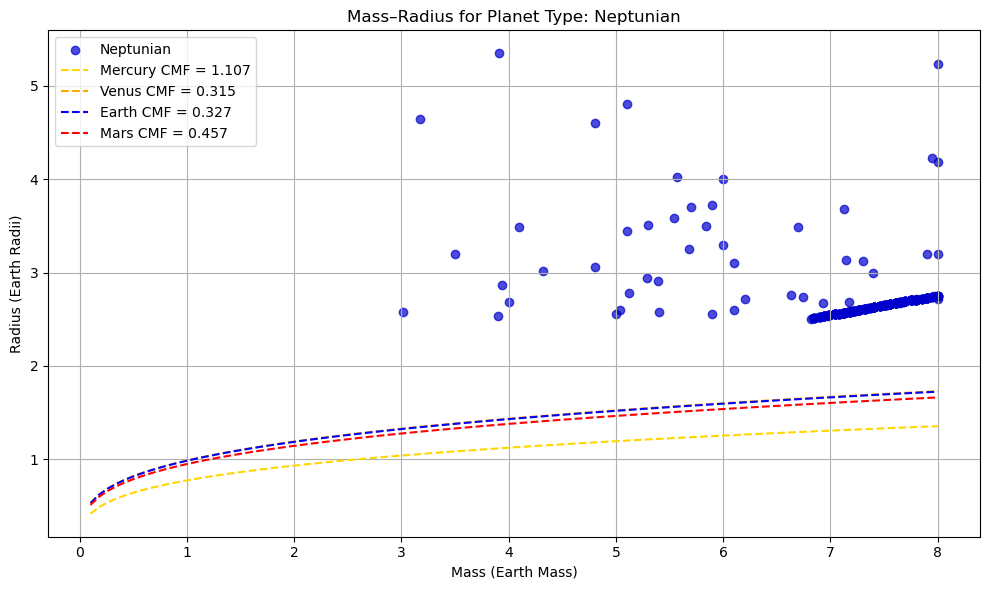

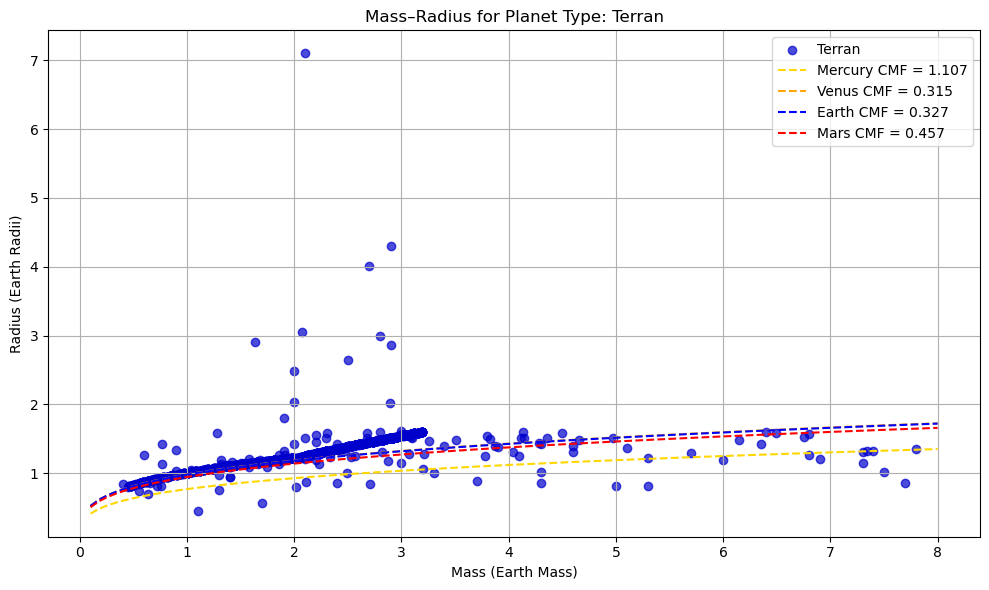

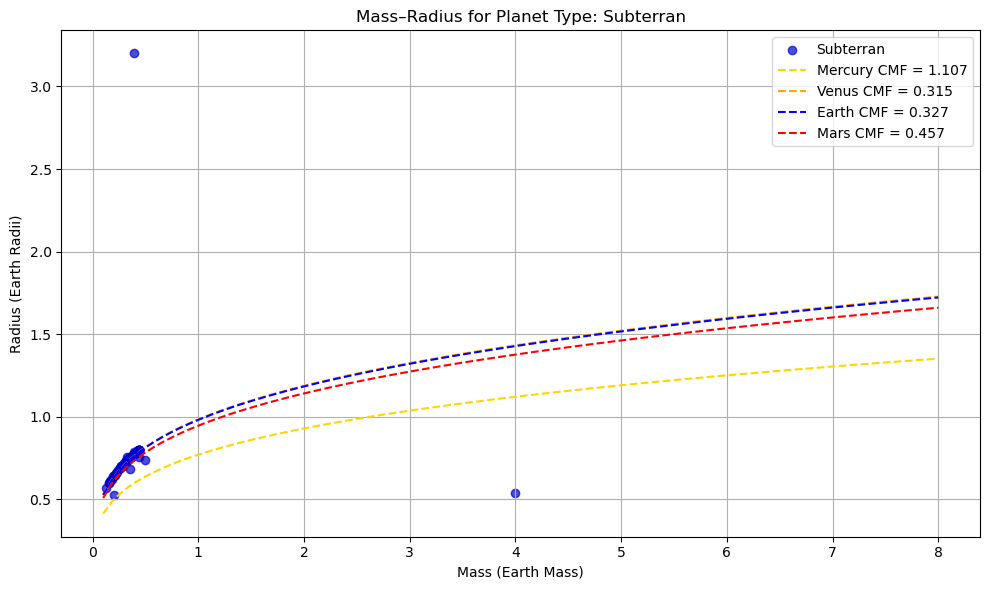

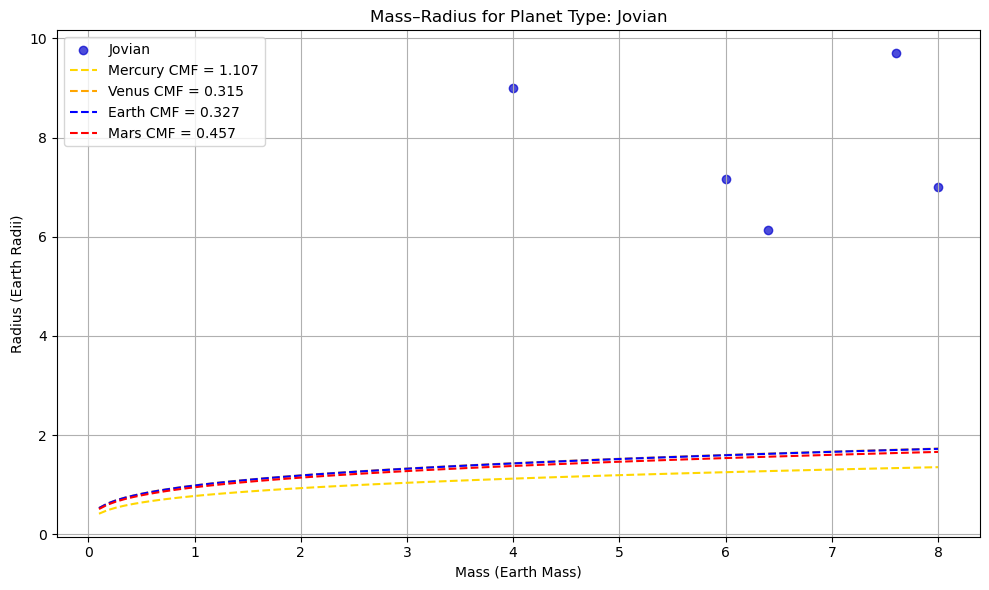

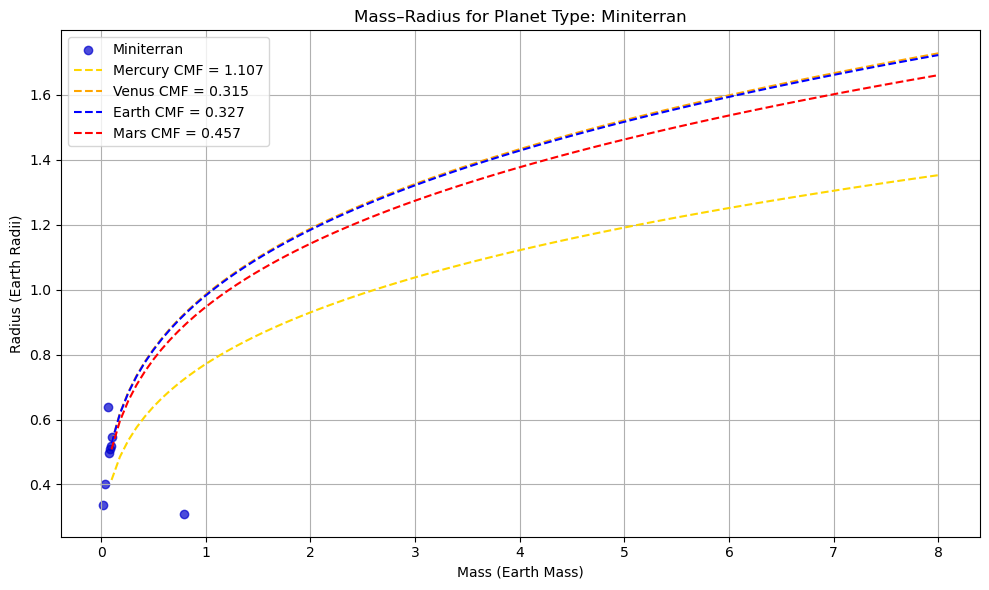

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import scipy.optimize as fit
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


df = pd.read_csv('hwc.csv')
#drop nan vals
df = df.dropna(subset=['P_MASS', 'P_RADIUS'])

x_data = df['P_MASS'] 
y_data = df['P_RADIUS']  
#reduce data to planets with mass under 8 earth masses
df = df[df['P_MASS'] <= 8]

# earth physical constants
M_oplus = 5.972e24  #mass in kg
R_oplus = 6.371e6   #radius in meters

# cmf and radius functions from resourced paper
def cmf_calc(R, M): 
    return (1 / 0.21) * (1.07 - ((R / R_oplus) / (M / M_oplus)**(1/3.7)))

def radius_func(cmf, M):
    return (1.07 - (0.27 * cmf)) * (M / M_oplus)**(1/3.7)

#terrestrial planet parameters (radii in meters, masses in kg)
terrestrial_radii = np.array([2.4397e6, 6.052e6, 6.38e6, 3.396e6])
terrestrial_masses = np.array([3.302e23, 4.87e24, M_oplus, 6.4191e23])

#calculate core mass fractions for the rocky planets
cmf_vals_rocky_planets = cmf_calc(terrestrial_radii, terrestrial_masses)

#generate mass values for the model curves in kg, then convert to Earth masses for plotting
merc_mass_vals_kg = np.linspace(0.1, 8, 100) * M_oplus
merc_mass_vals = merc_mass_vals_kg / M_oplus  # Now in Earth masses
merc_rad_vals = radius_func(cmf_vals_rocky_planets[0], merc_mass_vals_kg)  # in Earth radii

venus_mass_vals_kg = np.linspace(0.1, 8, 100) * M_oplus
venus_mass_vals = venus_mass_vals_kg / M_oplus
venus_rad_vals = radius_func(cmf_vals_rocky_planets[1], venus_mass_vals_kg)

earth_mass_vals_kg = np.linspace(0.1, 8, 100) * M_oplus
earth_mass_vals = earth_mass_vals_kg / M_oplus
earth_rad_vals = radius_func(cmf_vals_rocky_planets[2], earth_mass_vals_kg)

mars_mass_vals_kg = np.linspace(0.1, 8, 100) * M_oplus
mars_mass_vals = mars_mass_vals_kg / M_oplus
mars_rad_vals = radius_func(cmf_vals_rocky_planets[3], mars_mass_vals_kg)

#simulated data (mass in Earth masses, radius in Earth radii)
np.random.seed(42)
mass_sim = np.random.uniform(0.5, 8, 100)  # Already in Earth masses
radius_sim = radius_func(0.3, mass_sim * M_oplus) + np.random.normal(0, 0.1, 100)  # in Earth radii


plt.figure(figsize=(12, 8))

#filtered data
sns.scatterplot(
    data=df,
    x = x_data,
    y = y_data,   # Keep in Earth radii
    hue='P_TYPE',
    size='P_TYPE',
    sizes= (12, 50),
    color = "light:b",
    alpha=0.8
)

#plots for CMF of each rocky planet in our solar system
plt.plot(
    merc_mass_vals, 
    merc_rad_vals, 
    color='yellow', 
    linestyle='--', 
    label='Mercury: CMF = {:.6f}'.format(cmf_vals_rocky_planets[0])
)
plt.plot(
    venus_mass_vals, 
    venus_rad_vals, 
    color='orange', 
    linestyle='--', 
    label='Venus: CMF = {:.6f}'.format(cmf_vals_rocky_planets[1])
)
plt.plot(
    earth_mass_vals, 
    earth_rad_vals, 
    color='blue', 
    linestyle='--', 
    label='Earth: CMF = {:.6f}'.format(cmf_vals_rocky_planets[2])
)
plt.plot(
    mars_mass_vals, mars_rad_vals, 
    color='red', 
    linestyle='--', 
    label='Mars: CMF = {:.6f}'.format(cmf_vals_rocky_planets[3])
)

#simulated data
plt.scatter(
    mass_sim, 
    radius_sim, 
    color='gray', 
    alpha = 0.5, 
    label='Simulated Planets'
)
plt.title("Mass vs Radius With Planet Type and CMF Curves")
plt.xlabel("Mass (M$_\oplus$)")
plt.ylabel("Radius (R$_\oplus$)")
plt.legend(title="Planet Type")

plt.tight_layout()
plt.grid(True)
plt.show()

####################### FITTING AND RESIDUALS ###################################

def mass_radius_power_law( x , a1, e1, e2, a2):
    return (a1 * x**(e1 - e2) + a2)

#sort before fit
df_sorted = df.sort_values(by='P_MASS')
x_data = df_sorted['P_MASS']
y_data = df_sorted['P_RADIUS']

params, covariance = fit.curve_fit(
    mass_radius_power_law, 
    x_data, 
    y_data, 
    p0 = [1.5, 0.3,  0.2, 1])

a1, e1, e2, a2 = params

y_model = mass_radius_power_law(x_data, *params)
residuals = y_data - y_model

x_fit = np.linspace(x_data.min(), x_data.max(), 500)
y_fit = mass_radius_power_law(x_fit, *params)

#filtered data
plt.figure(figsize=(14, 8))

sns.scatterplot(
    data=df,
    x = x_data,
    y = y_data,   # Keep in Earth radii
    hue='P_TYPE',
    size='P_TYPE',
    sizes= (12, 50),
    color = "magma",
    alpha=0.8
)
#fit
plt.plot(
    x_fit, 
    y_fit, 
    color='red', 
    linestyle='--',
    label=f'Mass_Radius PWR Law: \n R ~ ({a1:.2f})x^{{({e1:.2f}) - ({e2:.2f})}} + {a2:.2f}'
)
plt.title("Mass vs Radius With Planet Type and Fit")
plt.xlabel("Mass (M$_\oplus$)")
plt.ylabel("Radius (R$_\oplus$)")
plt.legend()
plt.grid(True)
plt.show()

#residuals
plt.figure(figsize = (12,6))
plt.scatter(y_model, residuals, color="red")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Model Prediction (R$_\oplus$)")
plt.ylabel("Residuals (Observed - Model)")
plt.title("Residuals of Fit")
plt.grid(True)

plt.tight_layout()
plt.show()


#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################


df = pd.read_csv('hwc.csv')
#drop nan values
df = df.dropna(subset=['P_MASS', 'P_RADIUS', 'P_TYPE'])
#filter
df = df[df['P_MASS'] <= 8]

#physical constants
M_oplus = 5.972e24  # kg
R_oplus = 6.371e6   # m

# CMF and radius functions
def cmf_calc(R, M): 
    return (1 / 0.21) * (1.07 - ((R / R_oplus) / (M / M_oplus)**(1/3.7)))

def radius_func(cmf, M):
    return (1.07 - (0.27 * cmf)) * (M / M_oplus)**(1/3.7)

#basically just redoing what I did befoere with CMf values using physical vals for planets
terrestrial_radii = np.array([2.4397e6, 6.052e6, 6.38e6, 3.396e6])
terrestrial_masses = np.array([3.302e23, 4.87e24, M_oplus, 6.4191e23])
planet_names = ['Mercury', 'Venus', 'Earth', 'Mars']
colors = ['gold', 'orange', 'blue', 'red']

#CMF values for each
cmf_vals = cmf_calc(terrestrial_radii, terrestrial_masses)

#mass values for model curves (Earth masses)
mass_vals = np.linspace(0.1, 8, 100)
mass_vals_kg = mass_vals * M_oplus

# Generate model curves
model_curves = {
    name: radius_func(cmf, mass_vals_kg)
    for name, cmf in zip(planet_names, cmf_vals)
}

# Unique planet types
planet_types = df['P_TYPE'].unique()

#plot each planet type
for ptype in planet_types:
    subset = df[df['P_TYPE'] == ptype]

    plt.figure(figsize=(10, 6))
    plt.scatter(subset['P_MASS'], subset['P_RADIUS'], label=f'{ptype}', color='mediumblue', alpha=0.7)

    for name, color in zip(planet_names, colors):
        plt.plot(mass_vals, model_curves[name], label=f'{name} CMF = {cmf_vals[planet_names.index(name)]:.3f}', linestyle='--', color=color)

    plt.title(f'Mass–Radius for Planet Type: {ptype}')
    plt.xlabel('Mass (Earth Mass)')
    plt.ylabel('Radius (Earth Radii)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plt.show()